In [1]:
# csv read용
import os

# 불용어 확인용
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# 추출적 요약
import summa
from summa.summarizer import summarize

import matplotlib.pyplot as plt

# crawl
import re
from bs4 import BeautifulSoup

# 데이터 전처리 for문에서 진행 바(%) 지켜볼 수 있음
from tqdm import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
import numpy as np
import pandas as pd
from importlib.metadata import version
print(nltk.__version__)
print(tf.__version__)
print(pd.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3.6.5
2.6.0
1.3.3
1.2.0


In [2]:
os.getcwd()

'/aiffel/aiffel/workplace/Aiffel_Quest/QUEST12'

### Step1. 데이터 수집하기

In [3]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('./news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(10)

,headlines,text
48126,"Man sets ATM on fire, leaves 17-page letter on...",An unidentified man set an ATM on fire in Hyde...
84695,Good food to soldiers not always possible: Par...,Former Defence Minister Manohar Parrikar has a...
84183,Former executive sues Infosys over employee di...,Former head of immigration of Infosys in the U...
3498,Paine and bowlers were not on same page: Aus b...,Australia's bowling coach David Saker revealed...
23314,Minor pregnant after stepfather rapes her for ...,A 14-year-old girl was raped by her stepfather...
33519,Mohammad Shami's wife now accuses him of age-f...,Mohammad Shami's wife Hasin Jahan has accused ...
77095,JPMorgan to pay Ã¢ÂÂ¹29 crore for not giving ...,The US Consumer Financial Protection Bureau ha...
23538,Cow slaughtering bigger crime than terrorism: ...,Rajasthan BJP MLA Gyan Dev Ahuja has said that...
26995,No records of 280 births at Mother Teresa's ch...,Homes run by Mother Teresa's Missionaries of C...
67866,Donkey's owners fined after donkey bites orang...,A German court has ordered the owners of a don...


In [5]:
# 데이터 중복 샘플 유무 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
# 데이터 중복 샘플 제거
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [7]:
# 데이터프레임 null값 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [8]:
# 데이터프레임 null값 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
# 불용어 개수 및 내역 파악

# nltk.download('stopwords')

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

### Step2. 데이터 전처리하기(추상적 요약)

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [12]:
# # 전처리한 파일(CSV)가 없으면 아래를 수행하게끔
# if os.path.isfile('preprocessed_news_article.csv') == False:
#     # 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
#     clean_text = []

#     for sentence in tqdm(data['text'], desc="text 컬럼 전처리.."):
#         clean_text.append(preprocess_sentence(sentence, remove_stopwords=True))

#     # 전처리 한 데이터 길이 보자
#     print(f"Length of the `clean_text`: {len(clean_text)}")

#     # 전처리 후 출력
#     print("text 전처리 후 결과: ", clean_text[:5])
    
#     # 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
#     clean_headlines = []
    
#     for sentence in tqdm(data['headlines'], desc="headlines 컬럼 전처리.."):
#         clean_headlines.append(preprocess_sentence(sentence, remove_stopwords=False))

#     # 전처리 한 데이터 길이 보자
#     print(f"Length of the `clean_headlines`: {len(clean_headlines)}")

#     print("headlines 전처리 후 결과: ", clean_headlines[:5])
    
#     # 데이터를 DataFrame에 저장
#     data['text'] = clean_text
#     data['headlines'] = clean_headlines

#     # 빈 값을 Null 값으로 변환
#     data.replace('', np.nan, inplace=True)
#     print('=3')
    
#     # Null 값 여부 체크
#     data.isnull().sum()
    
#     # Null 값 제거 후, 전체 샘플 수 확인
#     data.dropna(axis=0, inplace=True)
#     print('전체 샘플수 :', (len(data)))
    
#     ## preprocessing된 DataFrame을 CSV로 백업
#     ## 이후 커널을 새로 돌리거나 한다면 전처리과정을 이 파일로 퉁 치자
#     data.to_csv('preprocessed_news_article.csv')
#     print("CSV 백업완료")
# else:
#     # 파일 만들어뒀으면 data는 그냥 이거로 퉁
#     data = pd.read_csv("./preprocessed_news_article.csv")
#     print("CSV read 완료!")
    

In [13]:
# 전체 text 데이터에 대한 전처리 
clean_text = []


# 시간이 많이 걸렸던 코드
# for text in data.text:
#     cleatn_text.append(preprocess_sentence(text))
    
for sentence in tqdm(data['text'], desc="text컬럼 전처리.."):
    clean_text.append(preprocess_sentence(sentence, remove_stopwords=True))
    
    
# 전처리 후 출력 
print("text 전처리 후 결과: ", clean_text[:5])

text컬럼 전처리..: 100%|██████████| 98360/98360 [09:38<00:00, 170.00it/s]

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [14]:
# 전체 text 데이터에 대한 전처리 
clean_headlines = []


# 시간이 많이 걸렸던 코드
# for text in data.text:
#     cleatn_text.append(preprocess_sentence(text))
    
for sentence in tqdm(data['headlines'], desc="headlines컬럼 전처리.."):
    clean_headlines.append(preprocess_sentence(sentence, remove_stopwords=False))
    
    
# 전처리 후 출력 
print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines컬럼 전처리..: 100%|██████████| 98360/98360 [00:16<00:00, 5814.34it/s]

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [27]:
data['text']= clean_text
data['headlines']= clean_headlines

In [47]:
data2 = pd.DataFrame(data['text'], columns=['text'])
data3 = pd.DataFrame(data['headlines'], columns=['headlines'])

In [51]:
pre_df = pd.concat([data3, data2], axis=1)
pre_df.to_csv('./preprocessed_news_article.csv', encoding='utf-8')

In [57]:
pre_df = pd.read_csv('./preprocessed_news_article.csv', encoding='utf-8', index_col=0)
pre_df

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...
...,...,...
98355,crpf jawan axed to death by maoists in chhatti...,crpf jawan tuesday axed death sharp edged weap...
98356,first song from sonakshi sinha noor titled uff...,uff yeh first song sonakshi sinha starrer upco...
98357,the matrix film to get reboot reports,according reports new version science fiction ...
98358,snoop dogg aims gun at clown dressed as trump ...,new music video shows rapper snoop dogg aiming...


In [58]:
pre_df.isnull().sum()

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


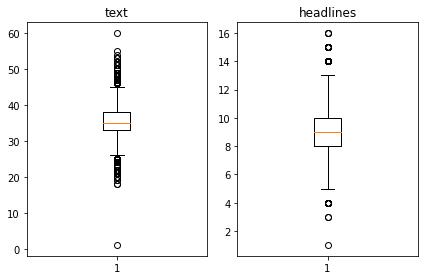

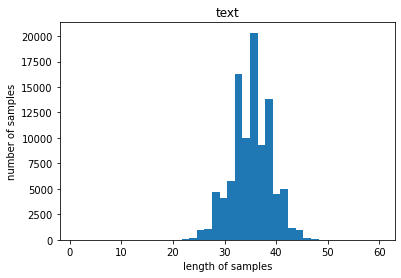

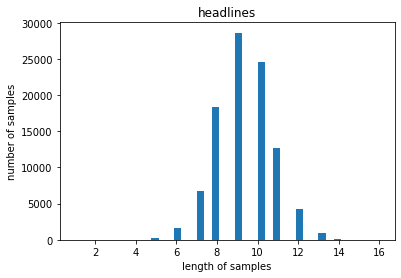

In [59]:
# 길이 분포 시각화 
text_len = [len(s.split()) for s in pre_df['text']]
headlines_len = [len(s.split()) for s in pre_df['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### Step3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [60]:
# text, headlines 최대 길이 임의 세팅
text_max_len = 50
headlines_max_len = 12
print('gogo')

gogo


In [61]:
# 데이터 비율 (최대길이 설정값 이하인 데이터들이 얼마나 있는지를 비율로 표시)
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('gogo')

# 비율 확인
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

gogo
전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [62]:
pre_df['text'].apply(lambda x:x if len(x.split()) <= text_max_len else None)
pre_df['headlines'].apply(lambda x:x if len(x.split()) <= headlines_max_len else None)

# 모든 열의 Null 값 제거
pre_df.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(pre_df)))

전체 샘플수 : 98360


In [63]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
pre_df['decoder_input'] = pre_df['headlines'].apply(lambda x : 'sostoken '+ x)
pre_df['decoder_target'] = pre_df['headlines'].apply(lambda x : x + ' eostoken')
pre_df.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [65]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(pre_df['text']) # 인코더의 입력
decoder_input = np.array(pre_df['decoder_input']) # 디코더의 입력
decoder_target = np.array(pre_df['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [66]:
# 훈련 데이터와 테스트 데이터 분리
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[10346 86431 90964 ... 41859 19133 90971]


In [67]:
# 정수 시퀀스를 이용해 다시 데이터 샘플 순서 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [68]:
# 섞인 데이터를 8:2 비율로 분리 (train_set : test_set = 8:2)
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [69]:
# 정의한 테스트 데이터 개수
# 이용하여 전체 데이터 양분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

## 노드기준 다음 값이 나와야 한다.
## 훈련 데이터 : 52,655개
## 테스트 데이터 13,163개

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [70]:
# Keras 토크나이저 사용
## 입력된 훈련 데이터로부터 단어 집합 만들기
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [71]:
# 빈도수 낮은 단어들 제외하기
## 7회 미만인 단어들은 훈련하지 않음(훈련데이터에서 제외처리)
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69582
등장 빈도가 6번 이하인 희귀 단어의 수: 47426
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22156
단어 집합에서 희귀 단어의 비율: 68.15843177833347
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4842248067769193


In [72]:
# 위에서 단어집합의 크기가 69582개 정도 나와서
## src_vocab을 69582으로 세팅
src_vocab = 69582
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [73]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[14, 2318, 870, 87, 1, 815, 2494, 2494, 391, 515, 1765, 5675, 274, 1744, 442, 95, 2656, 355, 4827, 3571, 243, 914, 190, 2058, 4], [50, 7065, 7912, 1, 5729, 374, 2482, 2162, 1128, 94, 2105, 262, 5873, 594, 1859, 4, 374, 948, 1006, 7065, 374, 227, 521, 145, 501, 2162, 985, 11, 262, 328, 294], [436, 978, 1436, 84, 2226, 2101, 887, 356, 1602, 167, 8, 1, 990, 1966, 396, 192, 7913, 29, 457, 978, 1966, 4606, 281, 296, 6717, 887, 167]]


In [74]:
# headlines 데이터도 다음을 수행
## Keras의 토크나이저 사용해서 decoder_input_train을 입력으로
## 전체 단어 집합과 각 단어에 대한 빈도수 계산
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [75]:
# 등장 빈도수가 6회 미만인 단어들의 비중 확인
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30064
등장 빈도가 5번 이하인 희귀 단어의 수: 19655
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10409
단어 집합에서 희귀 단어의 비율: 65.3771953166578
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.651392284520934


In [76]:
# 희귀 단어 제외시킬 경우의 단어 집합 크기가 2300~2400정도니
## 제거할 단어 크기 2000으로 설정
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 4, 525, 846, 7, 343, 1706, 15], [1, 59, 10, 451, 45, 31, 1617, 6, 1193], [1, 536, 352, 568, 295, 104, 7, 347], [1, 713, 40, 667, 40, 713, 667, 188, 76, 205], [1, 23, 10, 21, 17, 13, 3, 443, 223, 249]]
target
decoder  [[4, 525, 846, 7, 343, 1706, 15, 2], [59, 10, 451, 45, 31, 1617, 6, 1193, 2], [536, 352, 568, 295, 104, 7, 347, 2], [713, 40, 667, 40, 713, 667, 188, 76, 205, 2], [23, 10, 21, 17, 13, 3, 443, 223, 249, 2]]


In [77]:
# 빈 데이터들을 추출; 실제 길이는 1
## drop_train, drop_test에 각각 저장
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 12
삭제할 테스트 데이터의 개수 : 4
훈련 데이터의 개수 : 78676
훈련 레이블의 개수 : 78676
테스트 데이터의 개수 : 19668
테스트 레이블의 개수 : 19668


In [78]:
# 서로 다른 길이의 샘플들을 병렬 처리
## Padding 작업 수행
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


In [79]:
# 모델 설계하기
# 함수형 API 이용 (LSTM 1, 2, 3)
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Warning 메시지 무시하기
import warnings
warnings.filterwarnings('ignore')


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# [[YOUR CODE]]
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# [[YOUR CODE]]
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [80]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [81]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [82]:
## 어텐션 메커니즘을 수행하는 함수 추가
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [83]:
# 설계한 모델로 훈련하기
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 152s 466ms/step - loss: 3.8831 - val_loss: 3.5705
Epoch 2/50
308/308 [==============================] - 142s 460ms/step - loss: 3.3878 - val_loss: 3.2555
Epoch 3/50
308/308 [==============================] - 141s 458ms/step - loss: 3.1215 - val_loss: 3.0396
Epoch 4/50
308/308 [==============================] - 140s 454ms/step - loss: 2.9409 - val_loss: 2.9139
Epoch 5/50
308/308 [==============================] - 140s 454ms/step - loss: 2.8063 - val_loss: 2.8112
Epoch 6/50
308/308 [==============================] - 140s 455ms/step - loss: 2.6974 - val_loss: 2.7287
Epoch 7/50
308/308 [==============================] - 139s 453ms/step - loss: 2.6051 - val_loss: 2.6610
Epoch 8/50
308/308 [==============================] - 140s 454ms/step - loss: 2.5255 - val_loss: 2.6115
Epoch 9/50
308/308 [==============================] - 139s 451ms/step - loss: 2.4553 - val_loss: 2.5690
Epoch 10/50
308/308 [==============================] - 140s 453m

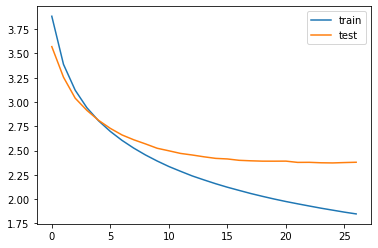

In [84]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [85]:
# 테스트 단계
## 정수 인덱스 행렬이던 텍스트 데이터를 실제 데이터로 복원해야함
# 필요한 3개의 사전 준비
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [86]:
# 정답이 없는 인퍼런스 모델에서는 별도 모델을 설계해야함
## 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야하기 때문
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [87]:
## 어텐션 메커니즘을 사용하는 출력층
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [88]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


### Step4. 실제 결과와 요약문 비교하기

In [89]:
# seq2text 함수처럼 요약문이 정수 시퀀스를 텍스트로 변환하는 seq2summary 함수 코드
## 작성 (Hint. 요약문에는 sostoken, eostoken을 고려해야함)\
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    # [[YOUR CODE]]
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [90]:
# 테스트 데이터 약 50개 샘플
## 실제 요약과 예측된 요약을 비교하시오
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : keeping view flight delays delhi government said use ghaziabad based air force base back indian air force given approval government said talks ongoing delhi airport airport allowed operations within kilometres delhi airport unless operating capacity 
실제 요약 : air force to be back up for delhi airport in 
예측 요약 :  cannot be allowed to delhi airport to delhi airport


원문 : twitter removed apps april june violated policies microblogging platform announced move access application allow app developers make automated twitter posts twitter limit apps tweets per three hours likes per day 
실제 요약 : twitter removes over lakh apps for 
예측 요약 :  twitter bans apps from its app


원문 : year old ias officer ashish drowned swimming pool foreign service institute delhi around midnight monday trying save female officer slipped pool others tried save woman safely rescued came pool found floating soon 
실제 요약 : ias in while woman officer 
예측 요약 :  ias officer shoots self in delhi


원문 : according data re

예측 요약 :  bjp slams bjp for its own party in india


원문 : actor vicky kaushal playing role sanjay dutt best friend biopic sanju said dutt seen best worst life seen us keep life man lived top bottom added vicky 
실제 요약 : dutt has seen best and worst did not see 
예측 요약 :  did not think am sanjay dutt on his th biopic


원문 : congress wednesday claimed goa administration collapse absence cm manohar parrikar hospitalised blood pressure issues party said parrikar hand administration senior minister coalition government proved afraid allies 
실제 요약 : goa almost after parrikar cong 
예측 요약 :  goa cm parrikar to goa cm parrikar


원문 : year old man accused raping class student naked women organisation nagaland district accused raped neighbour watching television residence spot handed police reportedly confessed raping minor 
실제 요약 : man accused of raping class girl naked in 
예측 요약 :  man rapes yr old girl in rape arrested


원문 : google india born ceo sundar pichai joining google parent company alpha

### Step5. Summa를 이용해서 추출적 요약해보기

In [7]:
import urllib
import requests
from summa.summarizer import summarize
import pandas as pd

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data5 = pd.read_csv('./news_summary_more.csv', encoding='utf-8')

data5.head()

# text = text_list['text'][0]

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [8]:
text_sum = []
for text in data5['text']:
    text_sum.append(str(text))

In [12]:
data5['summary'] = data5['text'].apply(lambda x: summarize(x, ratio=0.5))

In [13]:
data5['summary']

0        upGrad's Online Power Learning has powered 3 l...
1        Users get one CRED coin per rupee of bill paid...
2        The match witnessed India getting all out for ...
3        Also, customers have options to insure against...
4        Speaking about the sexual harassment allegatio...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    Michael B Jordan will reportedly play the lead...
98399    The video also shows a TV airing a news confer...
98400    Madhesi Morcha, an alliance of seven political...
Name: summary, Length: 98401, dtype: object

In [14]:
data5.sample(10)

,headlines,text,summary
18001,Pakistan sitting on huge amounts of dead capit...,Pakistan Prime Minister Imran Khan on Monday s...,Khan added that Pakistan was burdening its fut...
52363,India thrash Aus by 100 runs to begin their U1...,Three-time world champions India thrashed thre...,"Earlier, India had become the first team to sc..."
89074,Elon Musk shares his childhood picture of when...,SpaceX and Tesla Founder Elon Musk on Saturday...,SpaceX and Tesla Founder Elon Musk on Saturday...
86170,New Zealanders show visiting US official the m...,US State Secretary Rex Tillerson was 'welcomed...,US State Secretary Rex Tillerson was 'welcomed...
89970,Baahubali 2 wasn't promoted on comedy shows: K...,"Filmmaker Kunal Kohli in a tweet wrote, ""So th...",
73220,I once organised a surprise party for my birth...,"Neha Dhupia, who turned 37 on Sunday, said she...","Neha Dhupia, who turned 37 on Sunday, said she..."
75652,African country to release Lord Krishna coin o...,The Republic of Chad will release a limited ed...,251 out of the 501 coins will be made availabl...
21072,UAE forms committee to extend help to Kerala f...,The United Arab Emirates PM Sheikh Mohammed bi...,The United Arab Emirates PM Sheikh Mohammed bi...
24621,Alwar lynching victim died of 'shock': Post-mo...,"Alwar lynching victim Rakbar Khan died of ""sho...",Khan and his friend were attacked by a mob las...
7100,NASA shares first sounds from Mars,US space agency NASA on Friday shared the firs...,InSight had landed on Mars after completing it...


In [15]:
# 실제 요약과 추출된 요약 비교
for i in range(10):
    print("원문 :", data5['text'][i])
    print("실제 요약 :", data5['headlines'][i])
    print("추출 요약 :", data5['summary'][i])
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출 요약 : Users get one CRED coin per rupee of bill pai

Extractive 요약과 Abstractive 요약
1. 문법완성도:
    - Abstractive 요약은 문법 완성이 미흡하고, 일부 단어만 내뱉는 형식이라면, Extractive 요약은 문장의 완성도가 높은 편이다. 하지만 Extractive 요약역시 주요 핵심 내용을 요약한건 아니고, 일부 문장에서 키워드를 따와서 조합한 형식이다. 문단의 내용 자체를 대표하진 않는다.
    
2. 핵심단어:
    - 핵심단어 역시 Abstractive 해석은 일부 자주 나오는 형용사만 출력하는 반면, Extractive 형식은 정확한 핵심 키워드를 바꾸고 있지만, 실제 요약에 비해서는 불필요한 단어들까지 출력하고 있다. 


-----연습용------

In [104]:
pre_df = pd.read_csv('./preprocessed_news_article.csv', encoding='utf-8', index_col=0)
pre_df.head()

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...


In [105]:
text_sum = []
for text in pre_df['text']:
    text_sum.append(str(text))

In [106]:
pre_df['summary'] = pre_df['text'].apply(lambda x: summarize(x, ratio=0.005))

In [107]:
pre_df.sample(10)

,headlines,text,summary
12270,uk surgeons repair babies spinal cords while s...,team surgeons uk repaired spinal cords two bab...,
55889,match in random vote count on evms vvpat slips ec,senior official election commission said match...,
77750,patna hc rejects pils against nitish kumar new...,patna high court monday rejected two public in...,
43258,rumour was dated tusshar did not even have his...,radhika apte said rumors dating tusshar kapoor...,
5380,wv raman named india women coach despite kirst...,ex indian men cricket team opener wv raman app...,
47126,audience is open to actress performing heroic ...,sonakshi sinha said present times audience ope...,
92243,pakistan isi sheltering al qaeda chief in kara...,pakistan inter services intelligence agency sh...,
79028,uber rival grab gets billion funding from didi...,ride hailing app uber biggest southeast asia r...,
95265,self defense has nothing to do with someone se...,actress taapsee pannu said self defense concep...,
73376,sonam to star in film based on novel the zoya ...,sonam kapoor confirmed starring film based anu...,


In [108]:
# 실제 요약과 추출된 요약 비교
for i in range(10):
    print("원문 :", pre_df['text'][i])
    print("실제 요약 :", pre_df['headlines'][i])
    print("추출 요약 :", pre_df['summary'][i])
    print("\n")

원문 : saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers
실제 요약 : upgrad learner switches to career in ml al with salary hike
추출 요약 : 


원문 : kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit
실제 요약 : delhi techie wins free food from swiggy for one year on cred
추출 요약 : 


원문 : new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history
실제